In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import StatevectorSampler
from sklearn.metrics import classification_report
import logging
import warnings

logging.getLogger('qiskit').setLevel(logging.ERROR)
logging.getLogger('qiskit_machine_learning').setLevel(logging.ERROR)
logging.getLogger('qiskit.primitives').setLevel(logging.ERROR)

warnings.filterwarnings("ignore", message="No gradient function provided, creating a gradient function.*")

## Data Loading and Preprocessing

In [13]:
class EEGProcessor:
    def __init__(self, sampling_rate=250):
        self.sampling_rate = sampling_rate
        self.channel_names = ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'Cz', 'Pz', 'Oz']

    def load_paradigm_data(self, subject_num, paradigm_name):
        base_path = Path("Quantum_Brainathon-2025_Dataset")
        subject_dir = base_path / f"Subject_{subject_num}"
        eeg_file = subject_dir / f"Subject_{subject_num}_{paradigm_name}_eeg.csv"
        marker_file = subject_dir / f"Subject_{subject_num}_{paradigm_name}_markers.csv"
        eeg_data = pd.read_csv(eeg_file)
        markers = pd.read_csv(marker_file)
        return eeg_data, markers

    def apply_bandpass_filter(self, data, lowcut=1.0, highcut=40.0, order=5):
        nyquist = 0.5 * self.sampling_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
        return signal.filtfilt(b, a, data, axis=0)

    def extract_epochs(self, eeg_data, markers, pre_stimulus=0.2, post_stimulus=0.8):
        pre_samples = int(pre_stimulus * self.sampling_rate)
        post_samples = int(post_stimulus * self.sampling_rate)
        epochs = []
        valid_markers = []
        for _, marker in markers.iterrows():
            timestamp = marker['timestamp']
            idx = (eeg_data['timestamp'] - timestamp).abs().idxmin()
            if idx - pre_samples >= 0 and idx + post_samples < len(eeg_data):
                epoch = eeg_data.iloc[idx - pre_samples:idx + post_samples][self.channel_names].values
                epochs.append(epoch)
                valid_markers.append(marker)
        return np.array(epochs), pd.DataFrame(valid_markers)

## Feature Engineering

In [14]:
class FeatureExtractor:
    def __init__(self):
        self.frequency_bands = {
            'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13),
            'beta': (13, 30), 'gamma': (30, 45)
        }
        self.sampling_rate = 250

    def extract_band_powers(self, epoch):
        features = []
        for channel in range(epoch.shape[1]):
            channel_data = epoch[:, channel]
            nperseg = min(128, len(channel_data) - 1)
            freqs, psd = signal.welch(channel_data, fs=self.sampling_rate, nperseg=nperseg, noverlap=nperseg//2)
            for low, high in self.frequency_bands.values():
                mask = (freqs >= low) & (freqs <= high)
                power = np.mean(psd[mask]) if np.any(mask) else 0
                features.append(power)
        return np.array(features)

    def extract_connectivity(self, epoch):
        n_channels = epoch.shape[1]
        connectivity = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                corr = np.corrcoef(epoch[:, i], epoch[:, j])[0, 1]
                connectivity.append(corr)
        return np.array(connectivity)

## Quantum Circuit Design

In [15]:
def create_quantum_feature_map(n_qubits):
    return ZZFeatureMap(n_qubits, reps=1, entanglement='linear')

def create_variational_circuit(n_qubits):
    return RealAmplitudes(n_qubits, reps=2, entanglement='full')

## Plot Results

In [16]:
def plot_paradigm_results(accuracies, paradigm_names, title):
    plt.figure(figsize=(10, 5))
    bars = plt.bar(paradigm_names, accuracies)
    plt.title(title)
    plt.xlabel("Paradigm")
    plt.ylabel("Accuracy (%)")
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

def plot_confusion_matrices(confusion_matrices, paradigm_names):
    n_paradigms = len(paradigm_names)
    fig, axes = plt.subplots(1, n_paradigms, figsize=(5 * n_paradigms, 4))
    if n_paradigms == 1:
        axes = [axes]
    for ax, cm, name in zip(axes, confusion_matrices, paradigm_names):
        sns.heatmap(cm, annot=True, fmt='.2f', ax=ax, cmap='Blues')
        ax.set_title(f'{name} Confusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    plt.tight_layout()
    plt.savefig("confusion_matrices.png")
    plt.show()

## Main Analysis Pipeline

In [18]:
def get_label_from_marker(marker, paradigm):
    if paradigm == "oddball_paradigm":
        return 1 if "target" in str(marker['marker']).lower() else 0
    elif paradigm == "stroop_task":
        return 1 if "congruent" in str(marker['marker']).lower() else 0
    elif paradigm == "task-switching_paradigm":
        return 1 if "switch" in str(marker['marker']).lower() else 0
    elif paradigm == "dual-task_paradigm":
        return 1 if "dual" in str(marker['marker']).lower() else 0
    return 0

def main():
    eeg_processor = EEGProcessor()
    feature_extractor = FeatureExtractor()
    paradigms = ["oddball_paradigm", "stroop_task", "task-switching_paradigm", "dual-task_paradigm"]

    num_subjects = 5

    all_accuracies = {'vqc': [], 'gb': [], 'xgb': []}
    all_confusion_matrices = {'vqc': [], 'gb': [], 'xgb': []}

    for paradigm in paradigms:
        paradigm_accuracies = {'vqc': [], 'gb': [], 'xgb': []}
        paradigm_cms = {'vqc': [], 'gb': [], 'xgb': []}

        counter = 1
        subject_num = counter

        while counter <= num_subjects:
            
            print(f"Processing Subject {subject_num}, {paradigm}")
            eeg_data, markers = eeg_processor.load_paradigm_data(subject_num, paradigm)
            epochs, valid_markers = eeg_processor.extract_epochs(eeg_data, markers)

            features = []
            for epoch in epochs:
                filtered_epoch = eeg_processor.apply_bandpass_filter(epoch)
                band_powers = feature_extractor.extract_band_powers(filtered_epoch)
                connectivity = feature_extractor.extract_connectivity(filtered_epoch)
                features.append(np.concatenate([band_powers, connectivity]))
            features = np.array(features)

            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(features)
            n_qubits = 6
            pca = PCA(n_components=n_qubits)
            reduced_features = pca.fit_transform(scaled_features)
            labels = np.array([get_label_from_marker(marker, paradigm) for _, marker in valid_markers.iterrows()])

            unique_classes = np.unique(labels)
            if len(unique_classes) < 2:
                print(f"Warning: Subject {subject_num}, Paradigm {paradigm} has only one class ({unique_classes[0]}). Skipping SMOTE.")
                X_balanced, y_balanced = scaled_features, labels
            else:
                smote = SMOTE(random_state=42)
                X_balanced, y_balanced = smote.fit_resample(scaled_features, labels)

            X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

            if len(np.unique(y_train)) < 2:
                print(f"Skipping training for Subject {subject_num}, Paradigm {paradigm} because y_train has only one class ({np.unique(y_train)[0]}).")
                subject_num+=1
                continue

            X_train_reduced = pca.transform(X_train)
            X_test_reduced = pca.transform(X_test)
            feature_map = create_quantum_feature_map(n_qubits)
            var_circuit = create_variational_circuit(n_qubits)
            optimizer = SPSA(maxiter=50)  # Faster optimizer, fewer iterations
            quantum_classifier = VQC(
                feature_map=feature_map,
                ansatz=var_circuit,
                optimizer=optimizer,
                sampler=StatevectorSampler()
            )

            quantum_classifier.fit(X_train_reduced, y_train)
            y_pred_vqc = quantum_classifier.predict(X_test_reduced)
            accuracy_vqc = accuracy_score(y_test, y_pred_vqc) * 100
            cm_vqc = confusion_matrix(y_test, y_pred_vqc)
            paradigm_accuracies['vqc'].append(accuracy_vqc)
            paradigm_cms['vqc'].append(cm_vqc)

            gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
            gb_classifier.fit(X_train, y_train)
            y_pred_gb = gb_classifier.predict(X_test)
            accuracy_gb = accuracy_score(y_test, y_pred_gb) * 100
            cm_gb = confusion_matrix(y_test, y_pred_gb)
            paradigm_accuracies['gb'].append(accuracy_gb)
            paradigm_cms['gb'].append(cm_gb)

            xgb_classifier = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
            xgb_classifier.fit(X_train, y_train)
            y_pred_xgb = xgb_classifier.predict(X_test)
            accuracy_xgb = accuracy_score(y_test, y_pred_xgb) * 100
            cm_xgb = confusion_matrix(y_test, y_pred_xgb)
            paradigm_accuracies['xgb'].append(accuracy_xgb)
            paradigm_cms['xgb'].append(cm_xgb)

            print(f"\n--- XGBoost Classification Report for Subject {subject_num}, Paradigm: {paradigm} ---\n")
            print(classification_report(y_test, y_pred_xgb, digits=2))

            counter += 1
            subject_num += 1

        for clf in ['vqc', 'gb', 'xgb']:
            if paradigm_accuracies[clf]:
                avg_accuracy = np.mean(paradigm_accuracies[clf])
                avg_cm = np.mean(paradigm_cms[clf], axis=0)
                all_accuracies[clf].append(avg_accuracy)
                all_confusion_matrices[clf].append(avg_cm)
                print(f"Paradigm {paradigm} Average {clf.upper()} Accuracy: {avg_accuracy:.2f}%")

        print()
        print()

    print("\nGenerating visualizations...")
    for clf in ['vqc', 'gb', 'xgb']:
        if all_accuracies[clf]:
            plot_paradigm_results(all_accuracies[clf], paradigms, f"Average {clf.upper()} Accuracy by Paradigm")
            plot_confusion_matrices(all_confusion_matrices[clf], paradigms)

Processing Subject 1, oddball_paradigm

--- XGBoost Classification Report for Subject 1, Paradigm: oddball_paradigm ---

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        18
           1       0.91      0.91      0.91        22

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

Processing Subject 2, oddball_paradigm

--- XGBoost Classification Report for Subject 2, Paradigm: oddball_paradigm ---

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.91      0.95      0.93        22

    accuracy                           0.93        40
   macro avg       0.93      0.92      0.92        40
weighted avg       0.93      0.93      0.92        40

Processing Subject 3, oddball_paradigm

--- XGBoost Classification Report for Subject 3, Paradigm: oddba

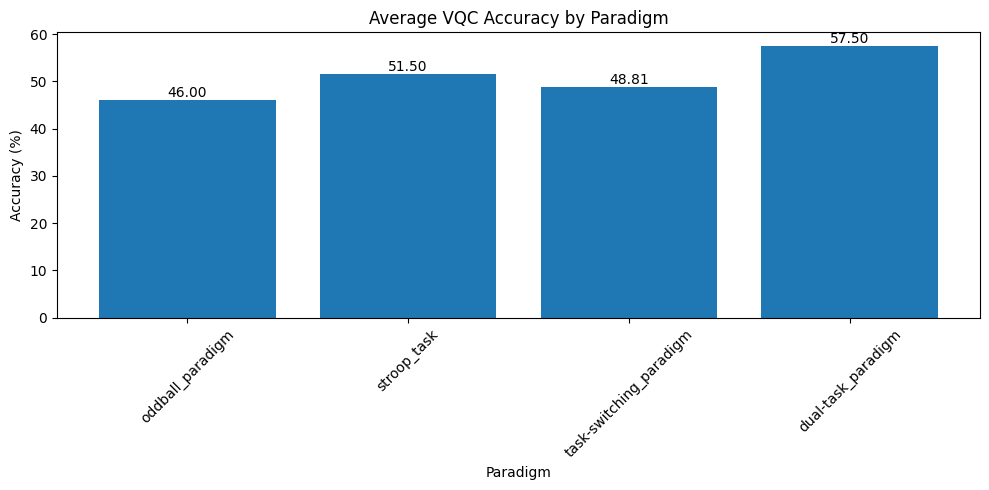

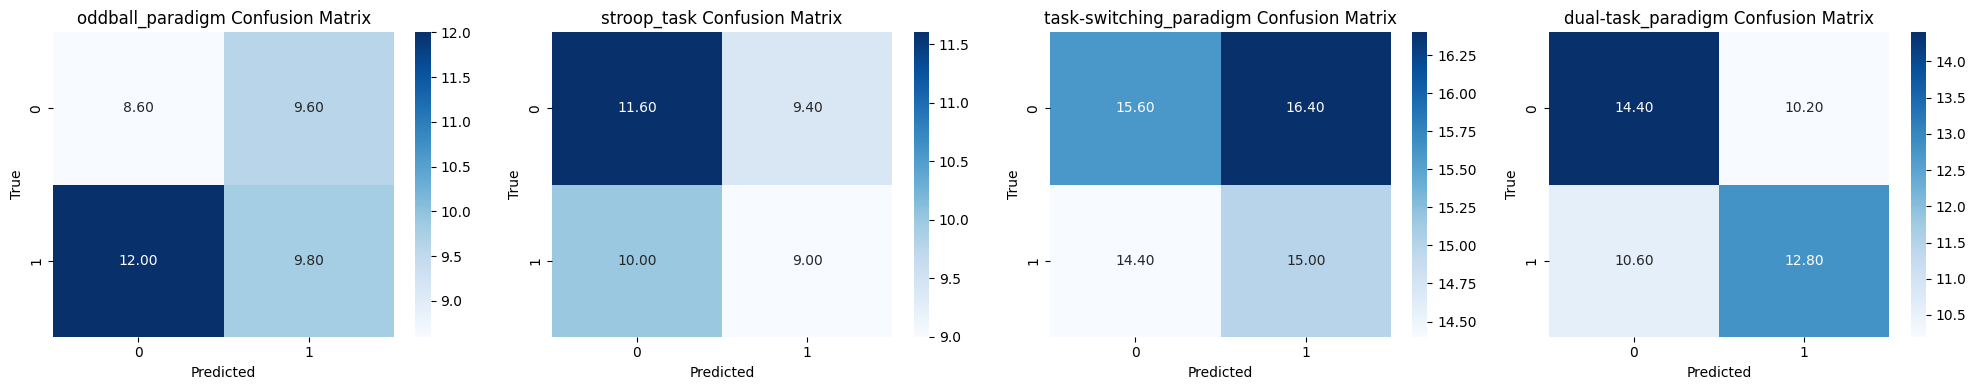

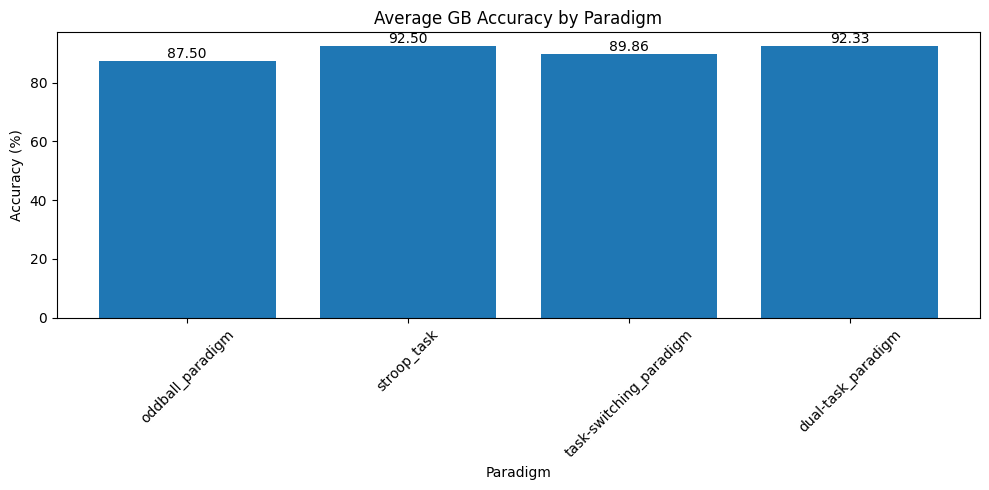

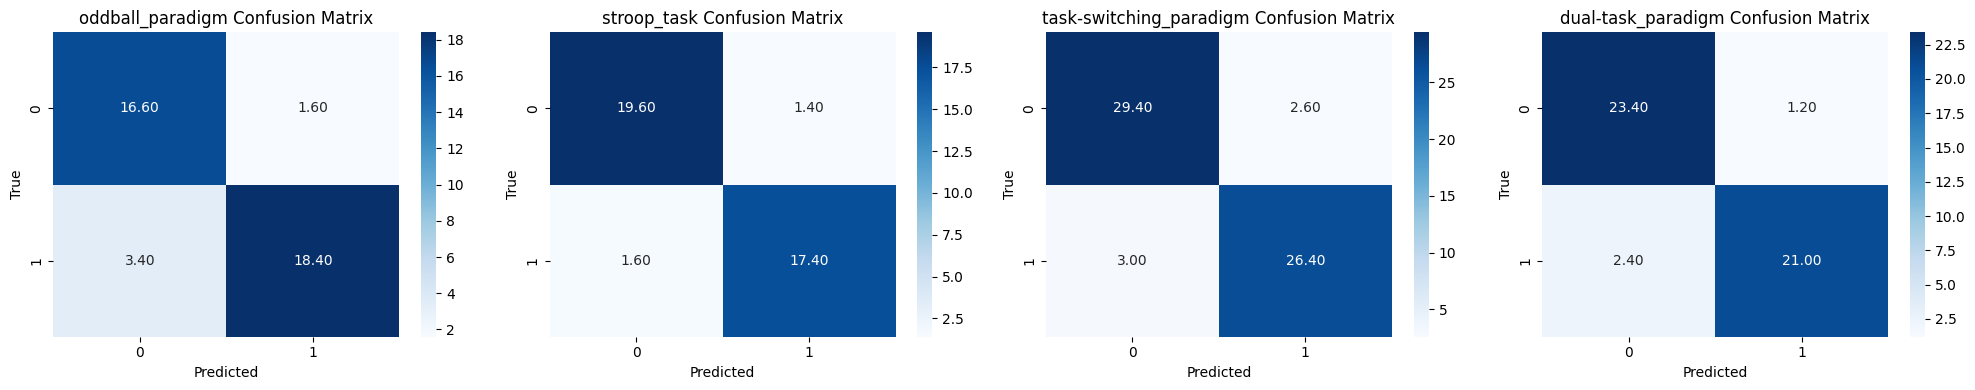

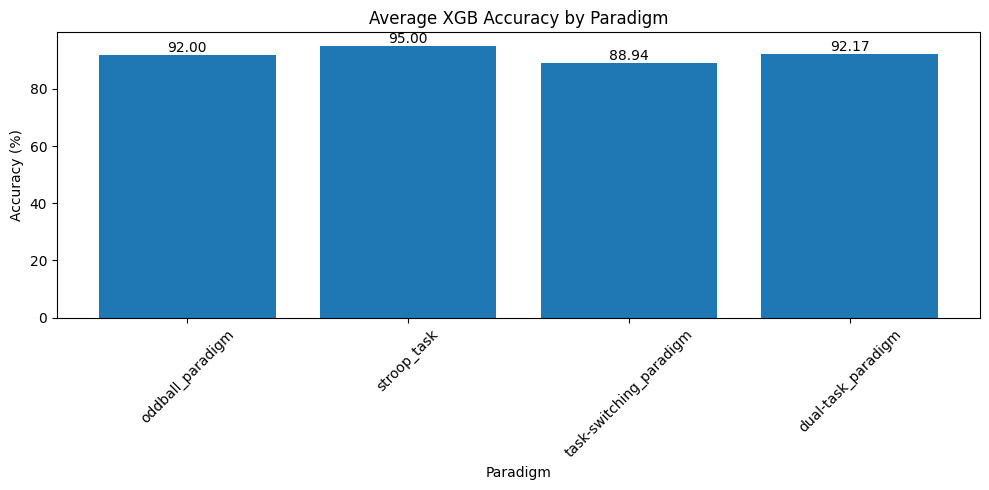

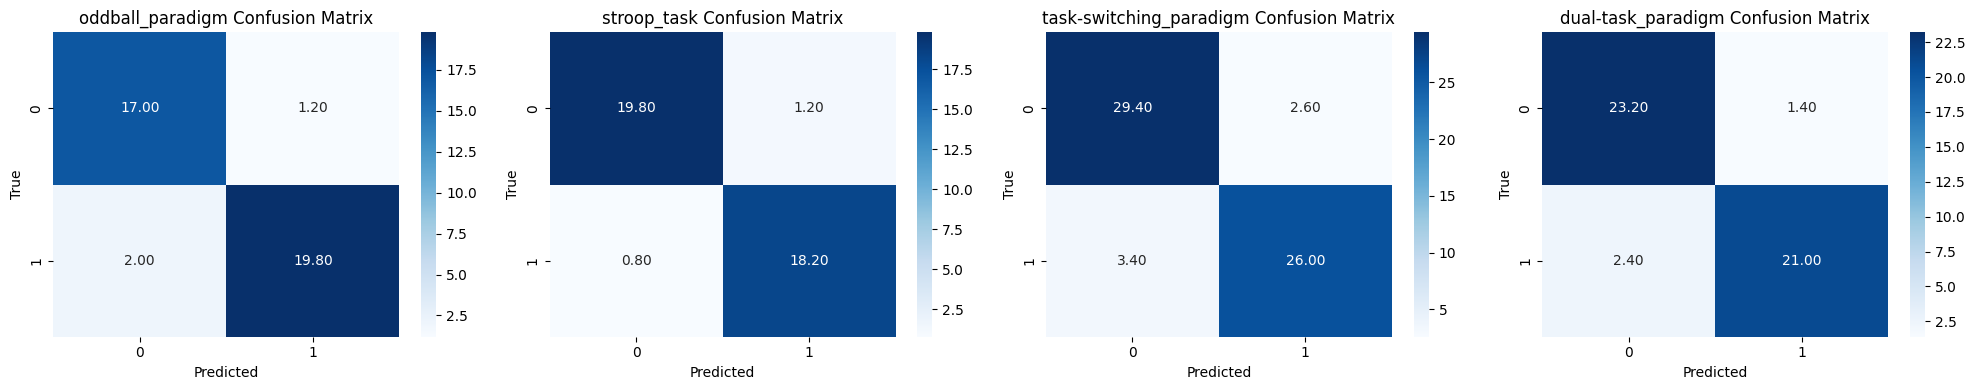

In [19]:
if __name__ == "__main__":
    main()

## Plotting Raw Signal Data

Looking for data file at: Quantum_Brainathon-2025_Dataset/Subject_5/Subject_5_baseline_eyesclosed_eeg.csv


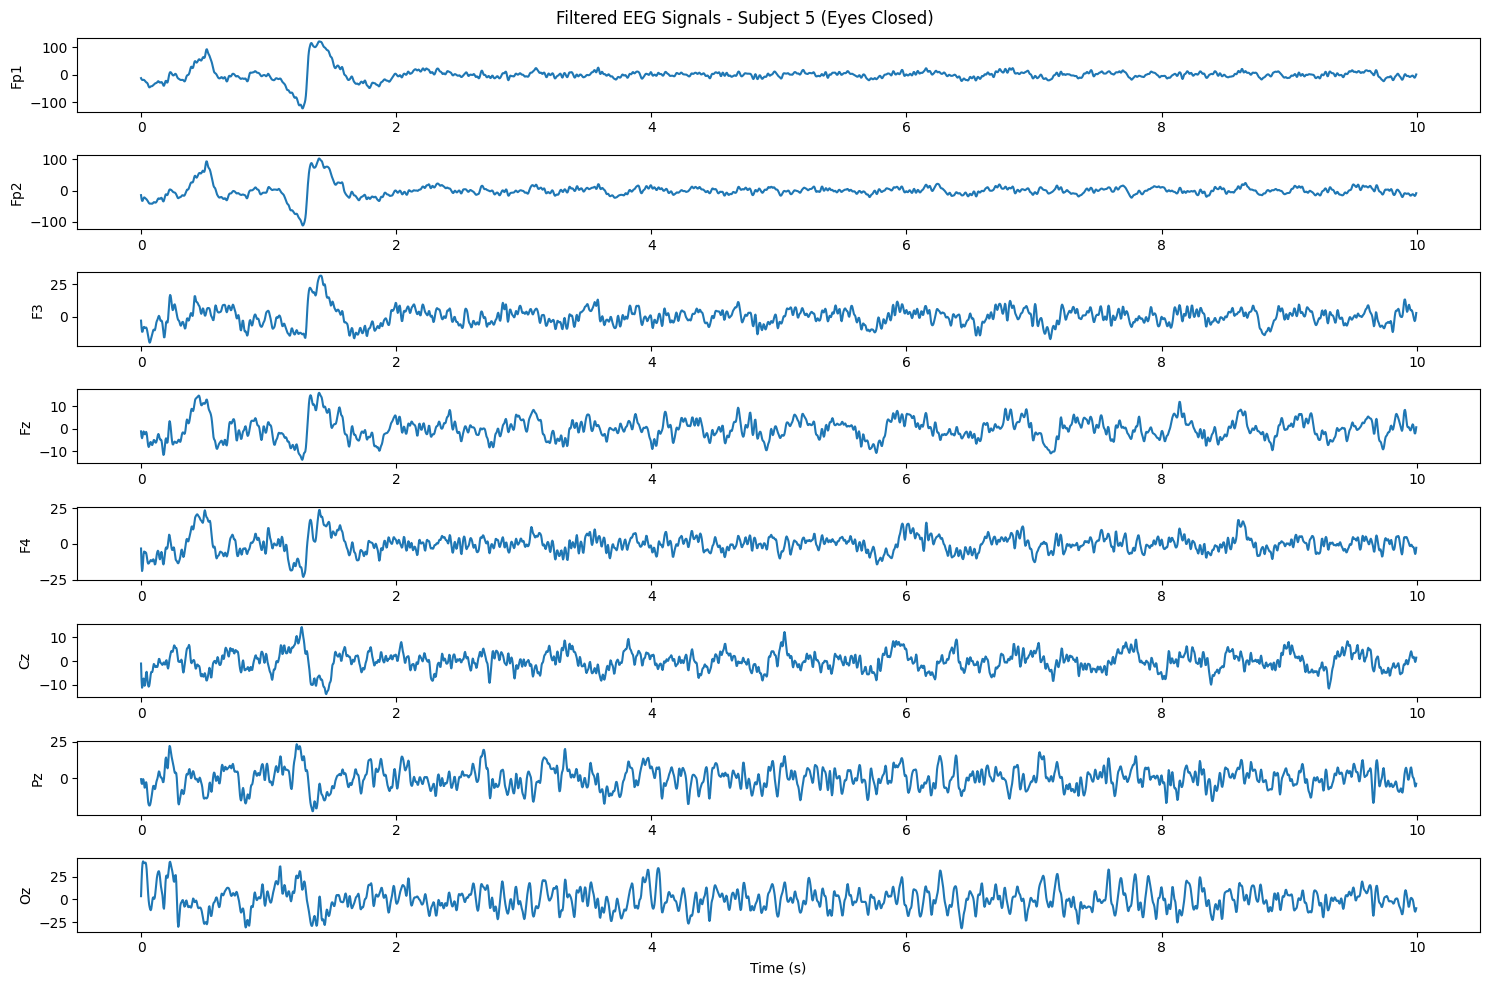

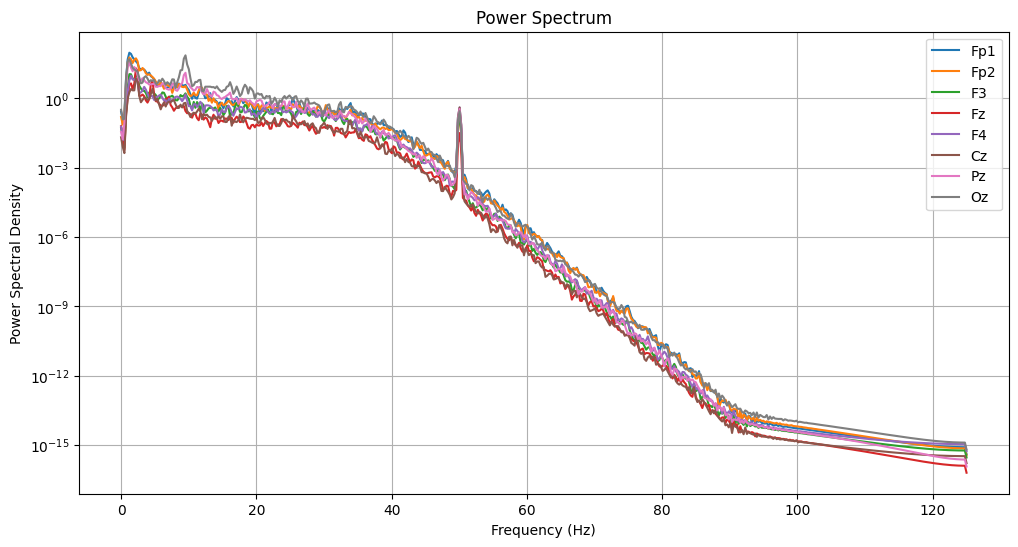

In [9]:
class EEGProcessor:
    def __init__(self, sampling_rate=250):
        self.sampling_rate = sampling_rate
        self.channel_names = ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'Cz', 'Pz', 'Oz']
        
    def load_eeg_data(self, file_path):
        """Load EEG data from CSV file."""
        try:
            df = pd.read_csv(file_path)
            if not all(channel in df.columns for channel in self.channel_names):
                missing = [ch for ch in self.channel_names if ch not in df.columns]
                raise ValueError(f"Missing channels in data: {missing}")
            self.timestamps = df['timestamp'].values
            self.eeg_data = df[self.channel_names].values
            return self.eeg_data
        except FileNotFoundError:
            print(f"Error: Could not find file: {file_path}")
            print("Please check if the file path is correct and the file exists.")
            sys.exit(1)
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            sys.exit(1)
    
    def apply_bandpass_filter(self, data, lowcut=1.0, highcut=40.0, order=5):
        """Apply bandpass filter to remove noise and unwanted frequencies."""
        nyquist = 0.5 * self.sampling_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
        filtered_data = signal.filtfilt(b, a, data, axis=0)
        return filtered_data
    
    def plot_raw_signals(self, data, title="Raw EEG Signals", duration=10):
        """Plot raw EEG signals for all channels."""
        samples = int(duration * self.sampling_rate)
        if samples > data.shape[0]:
            samples = data.shape[0]
        time = np.arange(samples) / self.sampling_rate
        
        plt.figure(figsize=(15, 10))
        for i, channel in enumerate(self.channel_names):
            plt.subplot(len(self.channel_names), 1, i+1)
            plt.plot(time, data[:samples, i])
            plt.ylabel(channel)
            if i == len(self.channel_names) - 1:
                plt.xlabel('Time (s)')
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    
    def plot_power_spectrum(self, data, channel_idx=None):
        """Plot power spectrum for specified channel or all channels."""
        if channel_idx is None:
            channel_idx = range(len(self.channel_names))
        elif isinstance(channel_idx, int):
            channel_idx = [channel_idx]
            
        plt.figure(figsize=(12, 6))
        for idx in channel_idx:
            f, pxx = signal.welch(data[:, idx], fs=self.sampling_rate, nperseg=1024)
            plt.semilogy(f, pxx, label=self.channel_names[idx])
        
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.title('Power Spectrum')
        plt.grid(True)
        plt.legend()
        plt.show()

def main():
    processor = EEGProcessor()
    
    base_path = Path("Quantum_Brainathon-2025_Dataset")
    data_path = base_path / "Subject_5" / "Subject_5_baseline_eyesclosed_eeg.csv"
    
    print(f"Looking for data file at: {data_path}")
    
    raw_data = processor.load_eeg_data(data_path)
        
    filtered_data = processor.apply_bandpass_filter(raw_data)
    processor.plot_raw_signals(filtered_data, title="Filtered EEG Signals - Subject 5 (Eyes Closed)")
    
    processor.plot_power_spectrum(filtered_data)

if __name__ == "__main__":
    main() 